In [9]:
!cp kaggle.json ~/.kaggle/

In [ ]:
! kaggle datasets download olekslu/makeup-lips-segmentation-28k-samples

In [130]:
from pathlib import Path
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from segmentation_models_pytorch import utils
import matplotlib.pyplot as plt
import cv2
import torch
import pandas as pd
import os
import numpy as np
import segmentation_models_pytorch as smp


In [104]:
DATA_ROOT = Path('/content/set-lipstick-original/')
IMAGES_PATH = '/content/set-lipstick-original/720p'
MASKS_PATH = '/content/set-lipstick-original/mask'

In [105]:
images = os.listdir(IMAGES_PATH)
masks = os.listdir(MASKS_PATH)

In [106]:
data = pd.read_csv('/content/set-lipstick-original/list.csv')

In [107]:
data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [108]:
for path in os.listdir(DATA_ROOT):
  if os.path.isdir(DATA_ROOT.joinpath(path)):
    print(path, ':', len(os.listdir(DATA_ROOT.joinpath(path))))

mask : 28540
720p : 28594


In [109]:
files_of_mask = [i for i in Path(DATA_ROOT.joinpath(MASKS_PATH)).iterdir()]

In [110]:
data = data.loc[data['mask'].isin([f.name for f in files_of_mask])]
data.reset_index(drop=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   width     28540 non-null  int64 
 2   height    28540 non-null  int64 
 3   class     28540 non-null  object
 4   xmin      28540 non-null  int64 
 5   ymin      28540 non-null  int64 
 6   xmax      28540 non-null  int64 
 7   ymax      28540 non-null  int64 
 8   mask      28540 non-null  object
dtypes: int64(6), object(3)
memory usage: 2.0+ MB


In [112]:
SIZE = 256
class LipsDataset(Dataset):
    
    def __init__(self, list_frame, size = 256, preprocessing=None):
        self.data = list_frame
        self.data_len = len(self.data.index)
        self.preprocessing = preprocessing
        self.size = size
      
    @staticmethod
    def resize(image, mask, size):
        img = cv2.cvtColor(cv2.imread(image), cv2.COLOR_RGB2BGR)
        img = cv2.resize(img, (size, size))
        img = np.array(img).astype('float')
        
        mask = cv2.cvtColor(cv2.imread(mask), cv2.COLOR_RGB2BGR)
        mask = cv2.resize(mask, (size, size))
        mask = np.array(mask).astype('float')
        mask = torch.as_tensor(mask)
        return img, mask

        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        data = self.data.iloc[idx]
        img_path = os.path.join(IMAGES_PATH, data['filename'])
        mask_path = os.path.join(MASKS_PATH, data['mask'])
        img, mask = LipsDataset.resize(img_path, mask_path, self.size )
       
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
            mask = self.preprocessing(mask)
            mask = torch.as_tensor(mask)
            
            
        else:
            img = torch.as_tensor(img) / 255.0
            mask = torch.as_tensor(mask) / 255.0
       
        img = img.permute(2,0,1)
        mask = mask.permute(2,0,1)

        
        return (img.float(), mask) 

torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


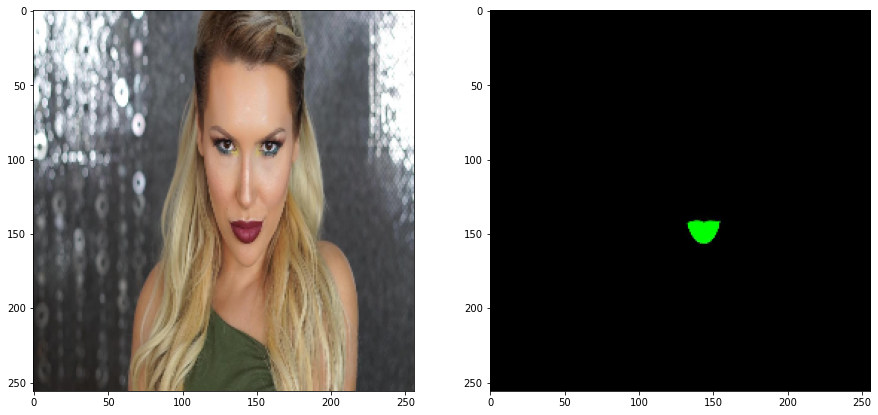

In [113]:
my_dataset = LipsDataset(data)
img, masks = my_dataset[0]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0))
plt.show()

In [114]:
train, test = train_test_split(data, test_size=0.2, random_state=42)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [115]:
train.shape, test.shape

((22832, 9), (5708, 9))

In [116]:
train_dataset = LipsDataset(train)

test_dataset = LipsDataset(test)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

valid_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False
)

torch.Size([8, 3, 256, 256]) torch.Size([8, 3, 256, 256])
tensor(0.) tensor(1.)
tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)


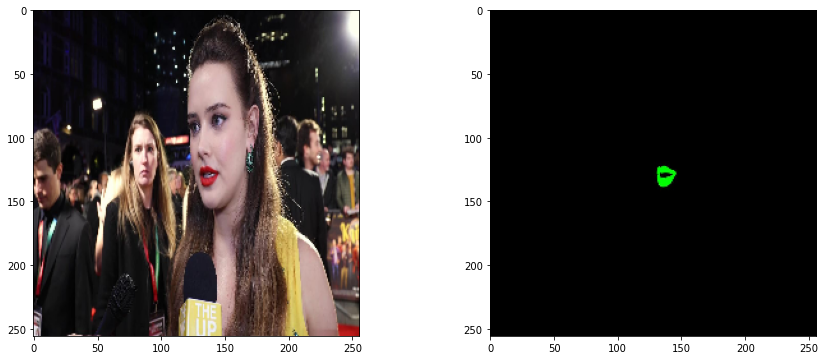

In [117]:
for img, target in train_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(target[0].permute(1, 2, 0))
    break

In [118]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [119]:
BACKBONE = 'resnet50'

model = smp.Unet(encoder_name=BACKBONE, classes=1, activation='sigmoid')
model.to(device)

preprocess_input = smp.encoders.get_preprocessing_fn(encoder_name=BACKBONE, pretrained='imagenet')

In [120]:
criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [121]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [122]:
max_score = 0

for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 1427/1427 [03:17<00:00,  7.23it/s, dice_loss - 0.03642, iou_score - 0.9316]
Model saved!


In [123]:
data_iter = iter(train_loader)

In [124]:
images, labels = data_iter.next()
images, labels = images.to(device), labels.to(device)

outputs = model(images)

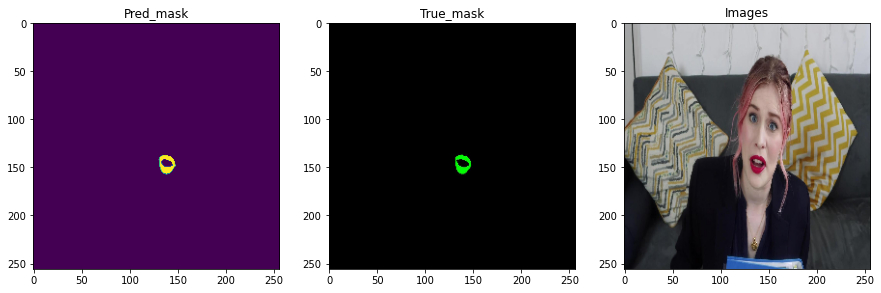

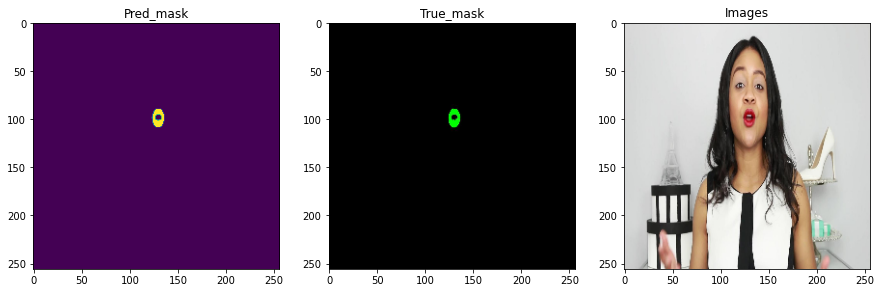

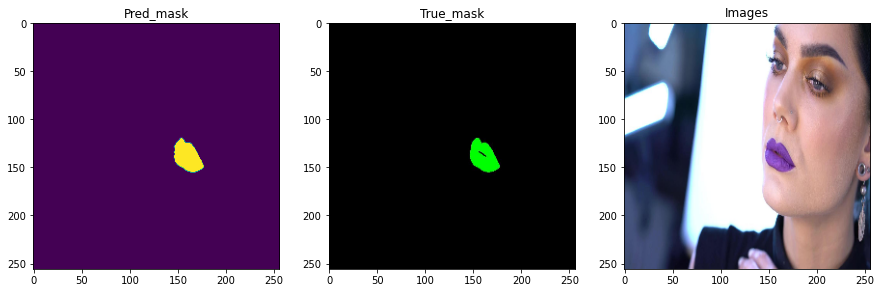

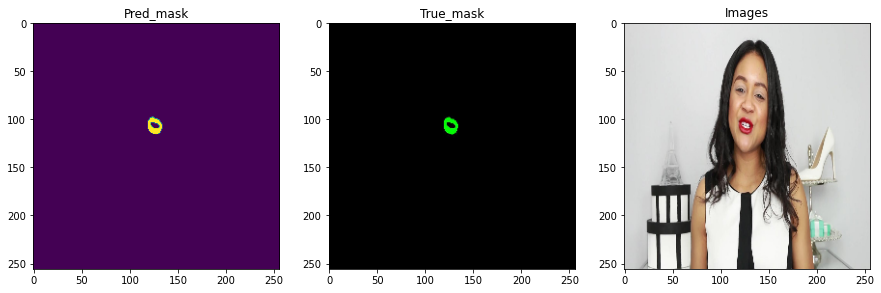

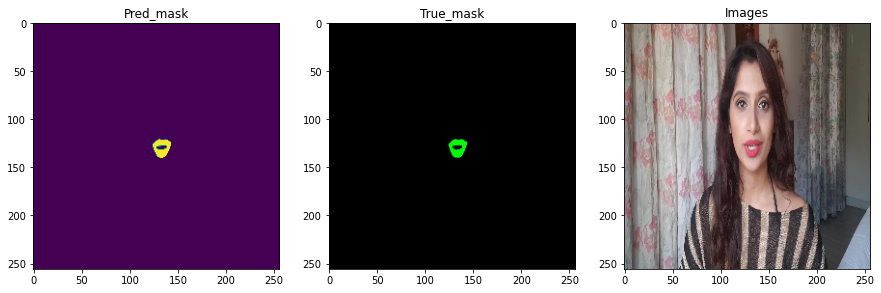

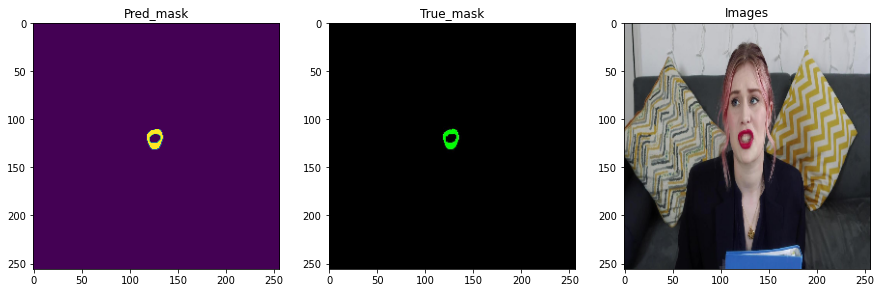

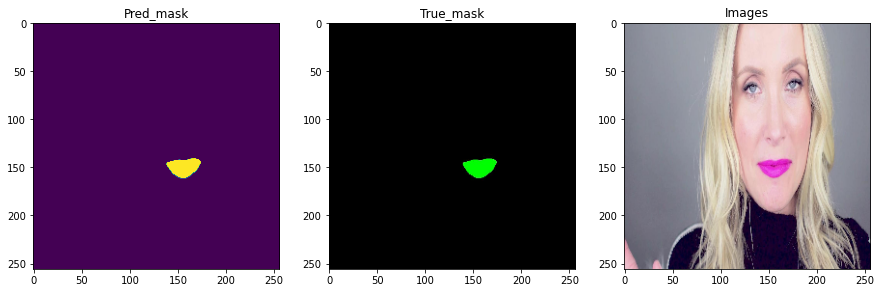

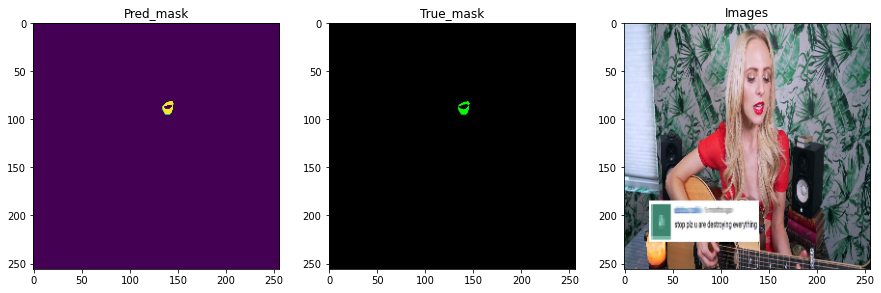

In [156]:
model.eval()
for i, data in enumerate(valid_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    f, ax = plt.subplots(1,3, figsize=(15, 6))
    for j in range(0, 4):
        ax[0].imshow(outputs.squeeze().detach().cpu().numpy()[j,:,:])
        ax[0].set_title('Pred_mask')
        ax[1].imshow(labels.squeeze().detach().cpu().numpy()[j,:, :].transpose(1,2,0))
        ax[1].set_title('True_mask')
        image = images[j].permute(1, 2, 0).cpu()
        ax[2].imshow(image)
        ax[2].set_title('Images')
        plt.show()
    if i > 6:
        break